In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../../../')
from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import wandb
import random
import tifffile as tiff
import glob

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [5]:
path="/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/"

In [62]:
patch_size = 64
train_images = tiff.imread(path+"train_data.tif")
train_y = tiff.imread(path+"train_label.tif")
val_images = tiff.imread(path+"val_data.tif")
val_y = tiff.imread(path+"val_label.tif")
test_images = tiff.imread(path+"test_data.tif")
test_y = tiff.imread(path+"test_label.tif")

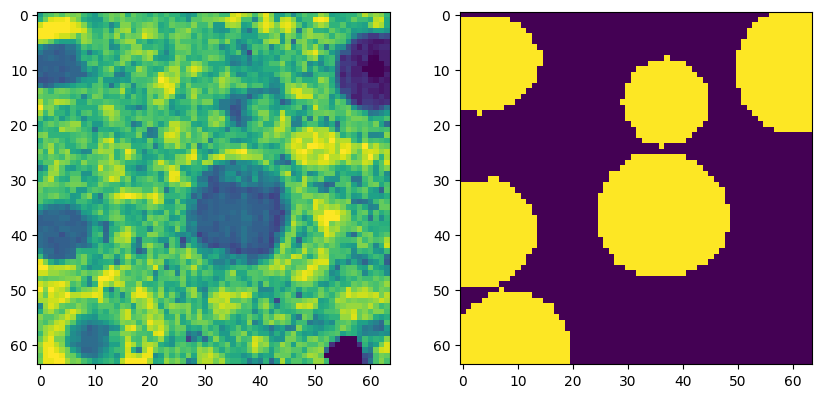

In [5]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(train_images[10000])
plt.subplot(1, 2, 2)
plt.imshow(train_y[10000])
plt.show()

In [68]:
xlist = []
print(len(train_y))
for batch_idx in range(len(train_y)):
        xlist.append(int(train_y[batch_idx][31][31]))
print(set(xlist))

65145
{0, 1, 2, 3}


In [3]:
import torch

In [70]:
a = torch.tensor([0])

In [71]:
b = torch.tensor([0])

In [72]:
a == b

tensor([True])

In [2]:
model_name = "Contrastive_MAE"
directory_path = "/group/jug/Sheida/HDN models/19022024/background added to negative pair/" 

# Data-specific
gaussian_noise_std = None
noiseModel = None 
# Training-specific
batch_size=128
virtual_batch = 64
lr=3e-4
max_epochs = 500
steps_per_epoch=400
test_batch_size=100

# Model-specific
num_latents = 5
z_dims = [32]*int(num_latents)
blocks_per_layer = 5
mask_size = 4
batchnorm = True
free_bits = 0.0 # if KLD is less than 1 then the loss won't be calculated
contrastive_learning = True

In [7]:
debug             = False #[True, False]
save_output       = True #[True, False]
project           = 'Contrastive_MAE'
img_shape = (64,64)

In [8]:
train_loader, val_loader, test_loader, data_mean, data_std = boilerplate._make_datamanager(train_images,train_y,val_images,val_y,
                                                                                           test_images,batch_size,
                                                                                           test_batch_size)

model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=img_shape,contrastive_learning=contrastive_learning,mask_size=mask_size).cuda()

model.train() # Model set in training mode

LadderVAE(
  (first_bottom_up): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): BottomUpDeterministicResBlock(
      (res): ResidualBlock(
        (block): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ELU(alpha=1.0)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): Dropout2d(p=0.2, inplace=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ELU(alpha=1.0)
          (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): Dropout2d(p=0.2, inplace=False)
        )
      )
    )
  )
  (top_down_layers): ModuleList(
    (0-3): 4 x TopDownLayer(
      (deterministic_block): Sequential(
        (0): TopDownDeterministicResBlock(
          (pre_conv): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), 

In [ ]:
training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=directory_path,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=model_name,val_loss_patience=30, debug=debug, save_output=save_output, project_name=project, batch_size=batch_size)

In [3]:
directory_path = "/group/jug/Sheida/HDN_models/22022024/Trained_model_5/model/"
trainHist=np.load(directory_path+"train_loss.npy")
model = torch.load(directory_path+"Contrastive_MAE_best_vae.net")
reconHist=np.load(directory_path+"train_reco_loss.npy")
klHist=np.load(directory_path+"train_kl_loss.npy")
clHist=np.load(directory_path+"train_cl_loss.npy")
valHist=np.load(directory_path+"val_loss.npy")

In [4]:
def distance(model, z1, z2):
    output1 = np.zeros((160, 4, 4))
    output2 = np.zeros((160, 4, 4))
    model.mode_pred=True
    model.eval()
    model.to(device)
    z1 = torch.from_numpy(z1)
    z1 = z1.to(device=device, dtype=torch.float)
    z1 = z1.reshape(1,1,patch_size,patch_size)
    z2 = torch.from_numpy(z2)
    z2 = z2.to(device=device, dtype=torch.float)
    z2 = z2.reshape(1,1,patch_size,patch_size)
    with torch.no_grad():
            sample1 = model(z1, z1)
            mu1 = sample1['mu']
            output1[:32] = mu1[0][0].cpu().numpy()[:,14:18,14:18]
            output1[32:64] = mu1[1][0].cpu().numpy()[:,6:10,6:10]
            output1[64:96] = mu1[2][0].cpu().numpy()[:,2:6,2:6]
            output1[96:128] = mu1[3][0].cpu().numpy()
            output1[128:160] = mu1[4][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)
            output1 = output1.T.reshape(-1,160)
            sample2 = model(z2, z2)
            mu2 = sample2['mu']
            output2[:32] = mu2[0][0].cpu().numpy()[:,14:18,14:18]
            output2[32:64] = mu2[1][0].cpu().numpy()[:,6:10,6:10]
            output2[64:96] = mu2[2][0].cpu().numpy()[:,2:6,2:6]
            output2[96:128] = mu2[3][0].cpu().numpy()
            output2[128:160] = mu2[4][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)
            output2 = output2.T.reshape(-1,160)
            return np.mean(np.sqrt(((output1-output2)**2).sum(axis=1)))

In [5]:
patch_size = 64
centre_size = 4
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
golgis = imread("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/granules/*.tif")
golgi_hist = []
num_golgi = len(golgis)
for i in tqdm(range(int(num_golgi/2))):
    golgi_hist.append(distance(model,golgis[i],golgis[num_golgi-i-1]))

 12%|█▏        | 62/525 [00:05<00:43, 10.66it/s]


ValueError: Expected parameter scale (Tensor of shape (1, 32, 32, 32)) of distribution Normal(loc: torch.Size([1, 32, 32, 32]), scale: torch.Size([1, 32, 32, 32])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[[[1.1749, 1.5548, 1.5668,  ..., 1.7765, 1.3333, 1.3158],
          [1.4147, 1.8345, 2.1572,  ..., 2.1119, 1.9150, 1.4093],
          [1.5094, 1.6358, 2.3190,  ..., 2.8103, 2.0348, 1.5043],
          ...,
          [1.5938, 3.1523, 5.4930,  ..., 1.7959, 1.6757, 1.3224],
          [2.2036, 1.8260, 2.3976,  ..., 1.2758, 1.3220, 1.2076],
          [1.0620, 1.5113, 1.5207,  ..., 1.2958, 1.2951, 1.0941]],

         [[1.4282, 1.4035, 1.7259,  ..., 1.7001, 1.4607, 1.2544],
          [1.1839, 1.5758, 1.8487,  ..., 2.0479, 2.2751, 1.5465],
          [1.7415, 1.7699, 3.7383,  ..., 2.5331, 2.3402, 1.4061],
          ...,
          [1.9041, 4.0534, 5.1527,  ..., 1.7108, 1.8764, 1.3297],
          [2.1069, 2.2172, 4.1997,  ..., 1.5360, 1.7618, 1.2510],
          [1.1676, 1.3698, 1.5272,  ..., 1.2536, 1.3693, 1.2059]],

         [[1.1074, 1.3100, 1.3875,  ..., 1.7626, 1.5397, 1.3261],
          [1.3452, 1.4262, 2.3203,  ..., 1.6547, 2.0419, 1.3893],
          [1.3377, 2.1599, 1.8718,  ..., 2.1138, 1.8361, 1.2311],
          ...,
          [2.0796, 2.7216, 6.7888,  ..., 1.4949, 1.7630, 1.1865],
          [1.6297, 2.7301, 1.6614,  ..., 1.5101, 1.3787, 1.1614],
          [1.1081, 1.3204, 1.4521,  ..., 1.1992, 1.2970, 1.0363]],

         ...,

         [[1.0082, 1.4461, 1.1669,  ..., 1.9221, 1.0860, 1.2540],
          [1.1591, 1.7100, 1.5196,  ..., 1.7794, 1.6377, 1.2795],
          [1.1198, 1.8598, 1.3318,  ..., 2.5101, 1.4799, 1.3675],
          ...,
          [2.2822, 1.9234, 5.7484,  ..., 1.4482, 1.6773, 1.2089],
          [1.3828, 1.2665, 2.2079,  ..., 1.3917, 1.3637, 1.1723],
          [1.2875, 1.0031, 1.6920,  ..., 1.1735, 1.3334, 1.1773]],

         [[1.1102, 1.3197, 1.0929,  ..., 1.4886, 1.1041, 1.3300],
          [1.0640, 1.5767, 1.4210,  ..., 1.7080, 1.4442, 1.2335],
          [1.2751, 1.8655, 1.5151,  ..., 2.2576, 1.7366, 1.6425],
          ...,
          [1.1003, 2.9009, 1.2298,  ..., 1.4918, 1.3489, 1.1886],
          [1.5487, 1.5081, 2.4377,  ..., 1.4683, 1.2668, 1.1930],
          [1.0626, 1.5239, 1.0420,  ..., 1.1803, 1.1736, 1.1244]],

         [[1.1954, 1.1299, 1.4630,  ..., 1.3394, 1.3615, 1.2055],
          [1.6444, 1.6682, 2.3087,  ..., 1.5324, 1.7451, 1.3148],
          [1.3134, 1.7563, 2.3340,  ..., 2.6021, 2.7458, 1.5628],
          ...,
          [2.8699, 3.5503, 9.6385,  ..., 1.4837, 1.5190, 1.2713],
          [1.2517, 2.6957, 2.7652,  ..., 1.6055, 1.4683, 1.3557],
          [1.1400, 1.4471, 1.7506,  ..., 1.2110, 1.2824, 1.0998]]]],
       device='cuda:0')

In [93]:
patch_size = 64
centre_size = 4
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
golgis = imread("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/mitochondria/*.tif")[:400,:,:]
mito = imread("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/granules/*.tif")[:400,:,:]
golgi_hist = []
num_golgi = len(golgis)
for i in tqdm(range(num_golgi)):
    golgi_hist.append(distance(model,golgis[i],mito[i]))

  0%|          | 0/400 [00:00<?, ?it/s]


ValueError: Expected parameter scale (Tensor of shape (1, 32, 2, 2)) of distribution Normal(loc: torch.Size([1, 32, 2, 2]), scale: torch.Size([1, 32, 2, 2])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[[[2.5401e+01,        inf],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         [[3.9241e-04, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [       inf, 4.7189e+37]],

         [[       inf, 1.0563e+16],
          [       inf,        inf]],

         [[0.0000e+00, 0.0000e+00],
          [       inf, 2.4378e-10]],

         [[0.0000e+00, 8.4078e-45],
          [0.0000e+00, 0.0000e+00]],

         [[3.7822e+11, 0.0000e+00],
          [1.2165e+19, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [       inf,        inf]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 2.8568e+19]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         [[1.3643e+12, 0.0000e+00],
          [4.6977e-29, 1.0315e-08]],

         [[0.0000e+00,        inf],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 1.2910e-28],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [2.6527e+33, 0.0000e+00]],

         [[1.5632e+05, 0.0000e+00],
          [       inf, 5.9540e-18]],

         [[0.0000e+00,        inf],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 1.3092e-03],
          [0.0000e+00, 0.0000e+00]],

         [[       inf,        inf],
          [       inf, 1.7269e+12]],

         [[       inf,        inf],
          [1.6172e-01,        inf]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 1.3658e-07]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [5.8512e+28, 1.5717e-21]],

         [[0.0000e+00, 4.0312e+22],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [       inf, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00,        inf]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]]]], device='cuda:0')

(array([ 1.,  1.,  2.,  2.,  1.,  9.,  6., 10.,  9., 18., 16., 19., 19.,
        11., 15., 18.,  9.,  7.,  9.,  9., 15., 11.,  6., 15., 10.,  9.,
         7., 11.,  7.,  6.,  7.,  8.,  1.,  4.,  4.,  3.,  3.,  4.,  5.,
         3.,  1.,  3.,  5.,  4.,  7.,  5.,  4.,  0.,  3.,  2.,  2.,  2.,
         0.,  7.,  4.,  1.,  3.,  2.,  2.,  2.,  1.,  0.,  2.,  0.,  0.,
         0.,  1.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([17.41408993, 17.67742923, 17.94076853, 18.20410783, 18.46744712,
        18.73078642, 18.99412572, 19.25746502, 19.52080432, 19.78414361,
        20.04748291, 20.31082221, 20.57416151, 20.83750081, 21.10084011,
        21.3641794 , 21.6275187 , 21.890858  , 22.1541973 , 22.4175366 ,
        22.68087589, 22.94421519, 23.20755449, 23.47089379, 23.73423309,
        23.99757239, 24.26091168, 24.52425098, 24.78759028, 25.050929

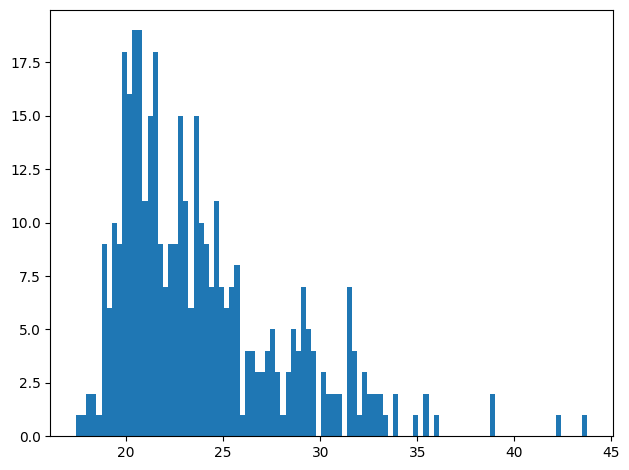

In [83]:
n_bins = 100
fig, axs = plt.subplots(1, 1, sharey=False, tight_layout=False)
axs.hist(golgi_hist, bins=n_bins)

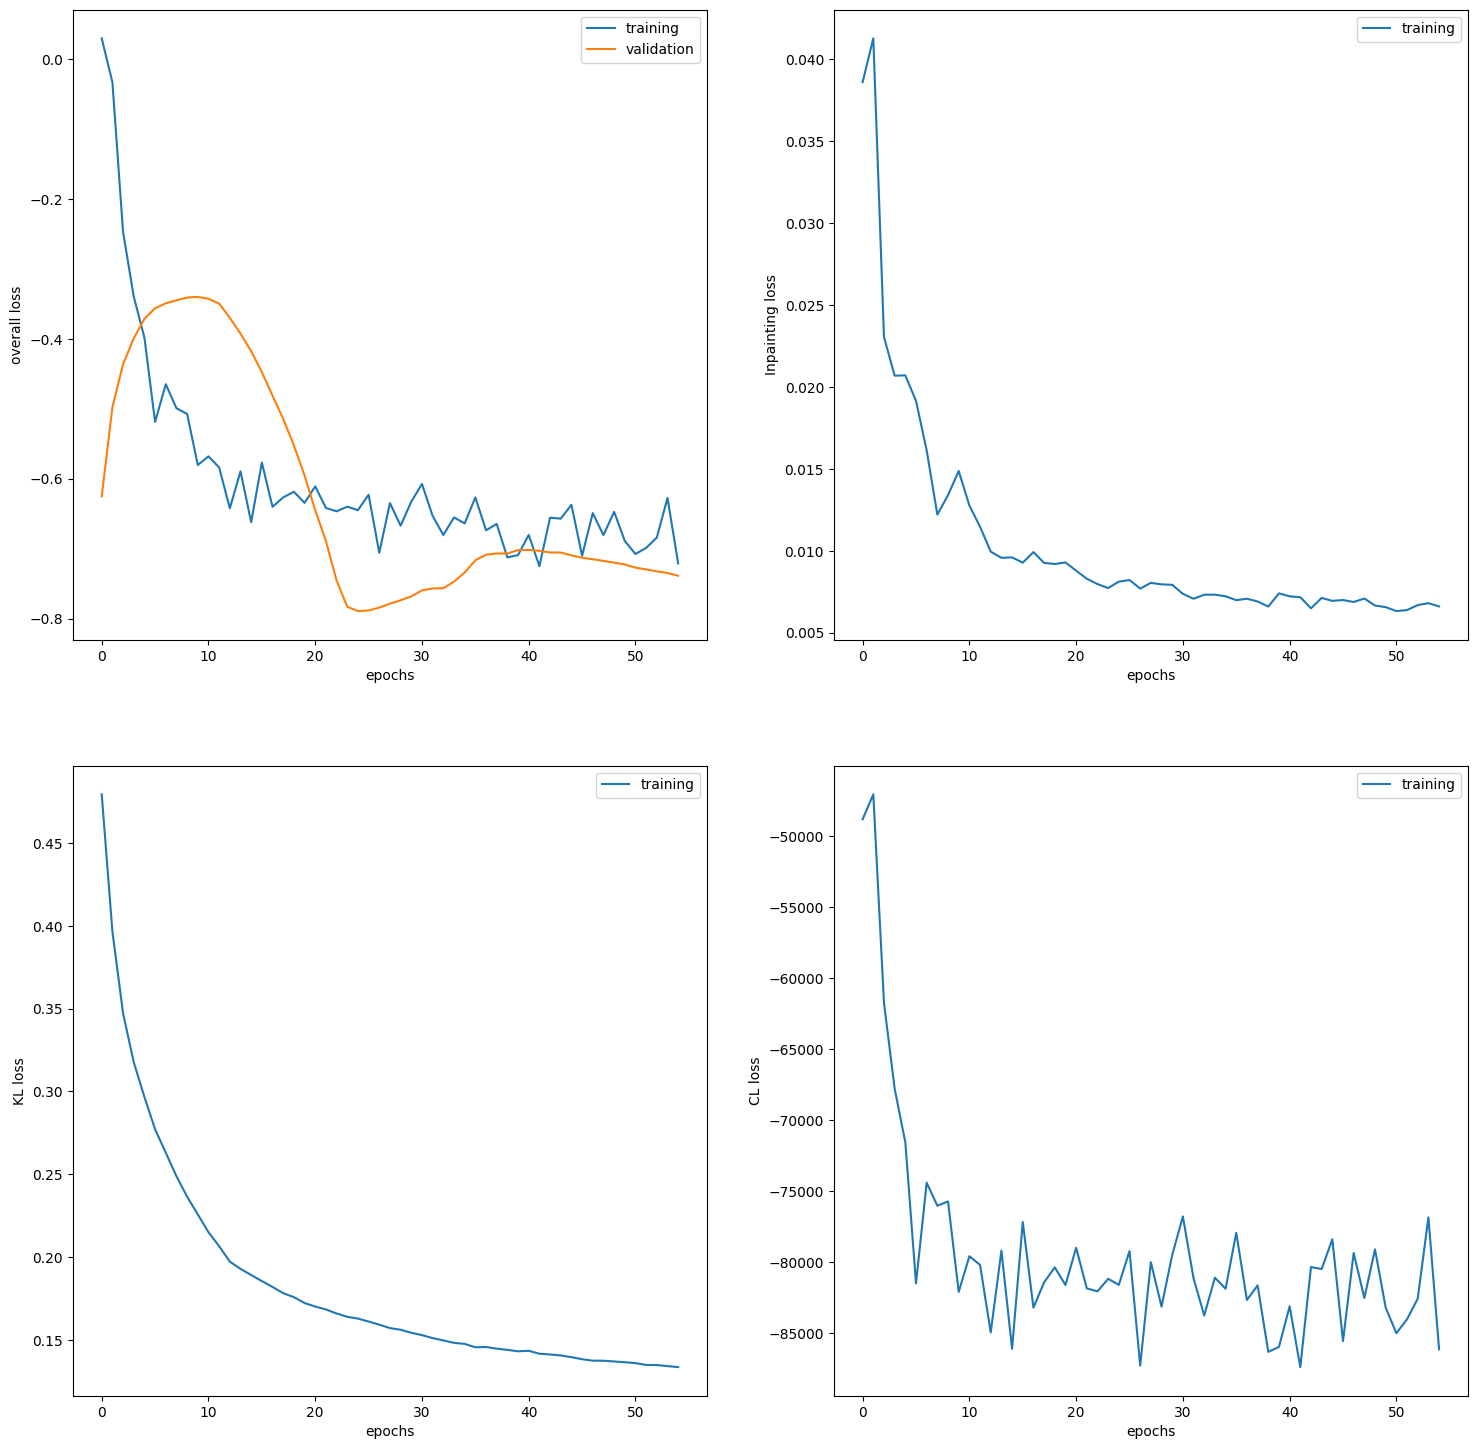

In [45]:
plt.figure(figsize=(18, 18))
plt.subplot(2,2,1)
plt.plot(trainHist,label='training')
plt.plot(valHist,label='validation')
plt.xlabel("epochs")
plt.ylabel("overall loss")
plt.legend()

plt.subplot(2,2,2)
plt.plot(reconHist,label='training')
plt.xlabel("epochs")
plt.ylabel("Inpainting loss")
plt.legend()

plt.subplot(2,2,3)
plt.plot(klHist,label='training')
plt.xlabel("epochs")
plt.ylabel("KL loss")
plt.legend()

plt.subplot(2,2,4)
plt.plot(clHist,label='training')
plt.xlabel("epochs")
plt.ylabel("CL loss")
plt.legend()
plt.show()